# Analyse exploratoire du jeu de données

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

### 1- Étudier la répartition par race et par type (chat/chien)

Le jeu de données est composé de 7349 lignes.
Chaque ligne a :
- un type : chat ou chien
- une race : 37 races différentes

In [9]:
# Lecture du fichier list.txt
df = pd.read_csv(
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",          # séparateur = espaces multiples
    comment="#",         # ignorer les lignes commençant par #
    header=None,         # pas d'en-tête dans les lignes de données
    names=["Image", "CLASS-ID", "SPECIES", "BREED_ID"]  # noms des colonnes
)

#On rajoute deux colonnes pour mieux labéliser les données
df["BREED_NAME"] = df["Image"].str.split("_").str[0] #On prend ce qu'il y a devant le "_" dans le nom de l'image
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"}) 
print(df.head())

            Image  CLASS-ID  SPECIES  BREED_ID  BREED_NAME SPECIES_NAME
0  Abyssinian_100         1        1         1  Abyssinian          Cat
1  Abyssinian_101         1        1         1  Abyssinian          Cat
2  Abyssinian_102         1        1         1  Abyssinian          Cat
3  Abyssinian_103         1        1         1  Abyssinian          Cat
4  Abyssinian_104         1        1         1  Abyssinian          Cat


On peut compter le nombre de chiens et de chats :

SPECIES_NAME
Dog    4978
Cat    2371
Name: count, dtype: int64


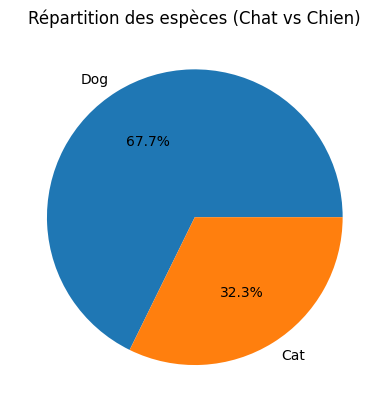

In [10]:
counts = df["SPECIES_NAME"].value_counts()
print(counts)
plt.pie(counts,labels=counts.index,autopct="%1.1f%%")
plt.title("Répartition des espèces (Chat vs Chien)")
plt.show()

On fait la même chose pour les races

BREED_NAME
american         400
english          396
basset           200
yorkshire        200
beagle           200
Birman           200
Bengal           200
chihuahua        200
great            200
german           200
British          200
japanese         200
leonberger       200
Maine            200
havanese         200
pug              200
pomeranian       200
Persian          200
miniature        200
Russian          200
shiba            200
wheaten          200
Sphynx           200
saint            200
Ragdoll          200
samoyed          200
Siamese          199
keeshond         199
scottish         199
boxer            199
Abyssinian       198
newfoundland     196
Egyptian         190
staffordshire    189
Bombay           184
Name: count, dtype: int64


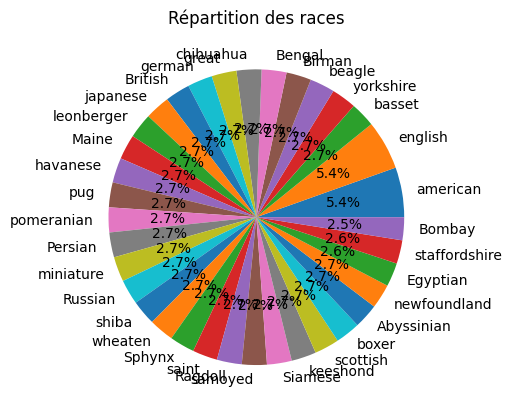

In [11]:
counts = df["BREED_NAME"].value_counts()
print(counts)
plt.pie(counts,labels=counts.index,autopct="%1.1f%%")
plt.title("Répartition des races")
plt.show()

### 2- Vérifier la cohérence et la qualité des masques de segmentation

Les masques de ségmentation se trouvent dans le dossier *oxford-iiit-pet/annotations/trimaps*.
Chaque image du jeu de données possède un masque associé qui délimite les pixels selon trois classes :
- 1 = Foreground (le corps de l'animal)
- 2 = Background (le fond de l'image)
- 3 = Not classified (on sait pas ce que sait)

Pour vérifier la cohérence et la qualité des masques, on va regarder à la main un petit échantillons, en affichant côte à côte les images et le masque associé.

Nombre de masques valides : 7390
indice: 1234 , nom de l'image: Birman_13


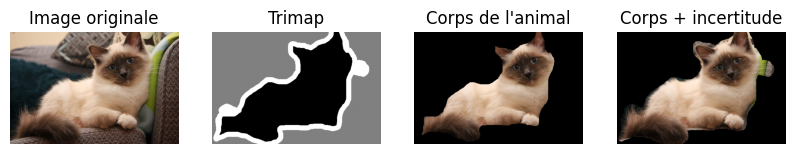

indice: 4321 , nom de l'image: miniature_pinscher_28


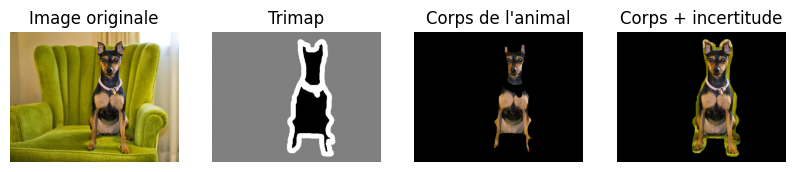

indice: 1000 , nom de l'image: Bengal_1


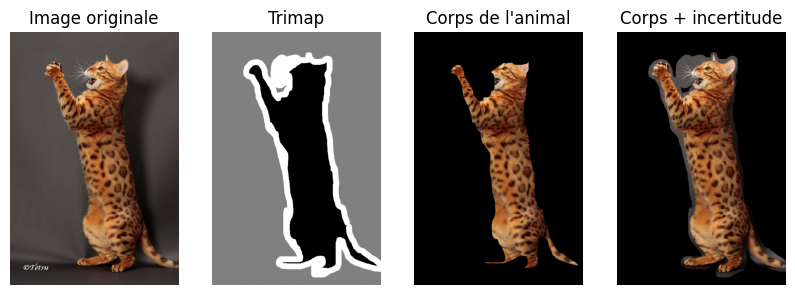

indice: 2000 , nom de l'image: chihuahua_1


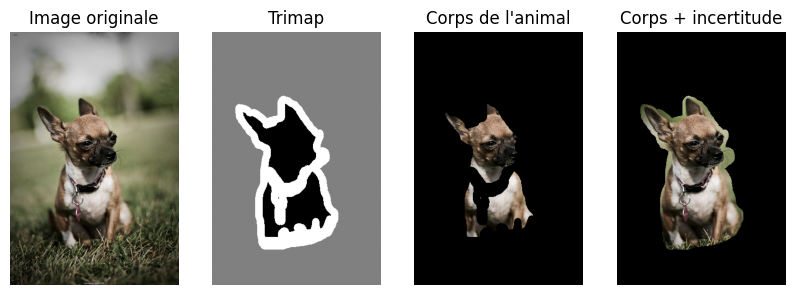

indice: 3000 , nom de l'image: great_pyrenees_1


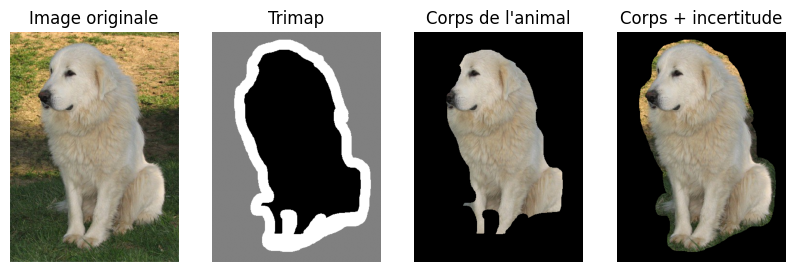

In [14]:

indices = [1234,4321,1000,2000,3000]# <-- Il suffit de changer l'indice pour choisir l'image que l'on veut vérifier (à choisir entre 0 et 7348)
img_dir = "oxford-iiit-pet/images/"
mask_dir = "oxford-iiit-pet/annotations/trimaps/"
masks = [f for f in os.listdir(mask_dir) if f.endswith(".png") and not f.startswith("._")]
print(f"Nombre de masques valides : {len(masks)}")
for indice in indices:
    example = masks[indice]
    name = os.path.splitext(example)[0]
    print("indice:",indice,", nom de l'image:",name)

    #On récupère les paths
    img_path = os.path.join(img_dir, name + ".jpg")
    mask_path = os.path.join(mask_dir, example)

    #On récupère les valeurs des pixels dans des np.array (on utilise la librairie PIL pour faire cela)
    img = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path))

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) 
    masked_img_moins= img.copy()
    masked_img_moins[mask != 1] = 0   # on garde seulement les pixels 1, on met tout le reste à 0 (en noir)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) et la zone d'incertitude (2)
    masked_img_plus= img.copy()
    masked_img_plus[mask == 2] = 0   # on garde seulement les pixels 1 et 3, on met les pixel 2 à 0 (en noir)

    #On affiche nos 4 images
    plt.figure(figsize=(10,5))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(masked_img_moins)
    plt.title("Corps de l'animal")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(masked_img_plus)
    plt.title("Corps + incertitude")
    plt.axis("off")

    plt.show()

En parcourant à la main les images, les masques semblent cohérents et de plutot bonne qualité.
Il peut y avoir des confusions lorsque l'animal porte un colier par exemple (indice 4321) mais dans l'ensemble on obtient ce qu'on attend du masque.

### 3- Identifier d’éventuels déséquilibres ou biais visuels

Je ne sais pas quoi dire ici